In [1]:
import sys
import subprocess

# Intentar instalar 'setuptools' si no está disponible
try:
    import pkg_resources
except ImportError:
    print("pkg_resources no está disponible. Instalando setuptools...")
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', 'setuptools'], stdout=subprocess.DEVNULL)
    import pkg_resources

from tqdm import tqdm

# Lista de paquetes necesarios
required = {'matplotlib', 'ipywidgets', 'numpy', 'PyQt5', 'scipy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    print("Faltan los siguientes paquetes:")
    for package in missing:
        print(f" - {package}")
    
    # Instalación de los paquetes faltantes con barra de progreso
    print("\nInstalando paquetes...")
    for package in tqdm(missing, desc="Progreso"):
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', package], stdout=subprocess.DEVNULL)
    print("\nTodos los paquetes necesarios han sido instalados.")
else:
    print("Todos los paquetes necesarios ya están instalados.")


C:\Users\USEER\AppData\Local\Temp\ipykernel_2944\3761468273.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Faltan los siguientes paquetes:
 - ipywidgets
 - PyQt5

Instalando paquetes...


Progreso: 100%|██████████| 2/2 [00:15<00:00,  8.00s/it]


Todos los paquetes necesarios han sido instalados.


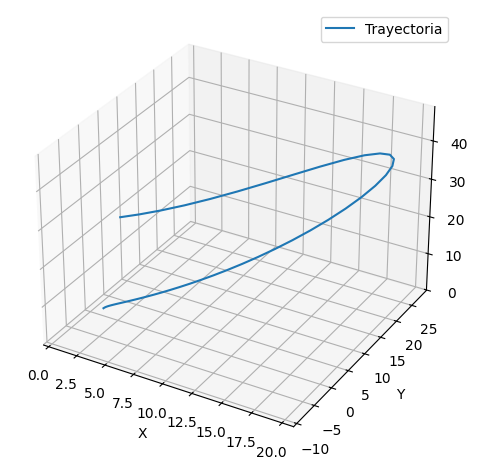

In [2]:
import sys
import numpy as np
from PyQt5 import QtWidgets, QtCore
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint

class SimulationCase(QtWidgets.QGroupBox):
    def __init__(self, title="Caso"):
        super().__init__(title)

        self.labelAlpha = QtWidgets.QLabel('Alpha:')
        self.inputAlpha = QtWidgets.QDoubleSpinBox()
        self.inputAlpha.setRange(0.01, 30.0)
        self.inputAlpha.setValue(1)
        self.inputAlpha.setSingleStep(0.01)

        self.labelBeta = QtWidgets.QLabel('Beta:')
        self.inputBeta = QtWidgets.QDoubleSpinBox()
        self.inputBeta.setRange(0.01, 30.0)
        self.inputBeta.setValue(1)
        self.inputBeta.setSingleStep(0.01)

        self.labelGamma = QtWidgets.QLabel('Gamma:')
        self.inputGamma = QtWidgets.QDoubleSpinBox()
        self.inputGamma.setRange(0.01, 30.0)
        self.inputGamma.setValue(1)
        self.inputGamma.setSingleStep(0.01)

        self.labelPosicion = QtWidgets.QLabel('Posición Inicial (x, y, z):')
        self.inputPosX = QtWidgets.QDoubleSpinBox()
        self.inputPosX.setRange(-100.0, 100.0)
        self.inputPosX.setValue(1.0)

        self.inputPosY = QtWidgets.QDoubleSpinBox()
        self.inputPosY.setRange(-100.0, 100.0)
        self.inputPosY.setValue(1.0)

        self.inputPosZ = QtWidgets.QDoubleSpinBox()
        self.inputPosZ.setRange(-100.0, 100.0)
        self.inputPosZ.setValue(1.0)

        self.labelTime = QtWidgets.QLabel('Tiempo de Simulación (s):')
        self.inputTime = QtWidgets.QDoubleSpinBox()
        self.inputTime.setRange(1, 100)
        self.inputTime.setValue(10)

        self.simulateButton = QtWidgets.QPushButton(f"Simular {title}")

        # Layout para los inputs y labels
        layout = QtWidgets.QGridLayout()
        layout.addWidget(self.labelAlpha, 0, 0)
        layout.addWidget(self.inputAlpha, 0, 1)
        layout.addWidget(self.labelBeta, 1, 0)
        layout.addWidget(self.inputBeta, 1, 1)
        layout.addWidget(self.labelGamma, 2, 0)
        layout.addWidget(self.inputGamma, 2, 1)
        layout.addWidget(self.labelPosicion, 3, 0)
        layout.addWidget(self.inputPosX, 3, 1)
        layout.addWidget(self.inputPosY, 3, 2)
        layout.addWidget(self.inputPosZ, 3, 3)
        layout.addWidget(self.labelTime, 4, 0)
        layout.addWidget(self.inputTime, 4, 1)
        layout.addWidget(self.simulateButton, 5, 0, 1, 4)

        self.setLayout(layout)

class NanodronApp(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Simulación de Nanodron")
        self.setGeometry(100, 100, 1200, 600)

        # Crear instancias de los casos A y B
        self.caseA = SimulationCase("Caso A")
        self.caseB = SimulationCase("Caso B")

        # Crear barra de progreso, etiqueta de cronómetro y botón de créditos
        self.progressBar = QtWidgets.QProgressBar()
        self.timerLabel = QtWidgets.QLabel('0.0 s')
        self.exitButton = QtWidgets.QPushButton("Salir")
        self.creditButton = QtWidgets.QPushButton("Créditos")

        # Layout para la barra de progreso y el cronómetro
        self.progressLayout = QtWidgets.QHBoxLayout()
        self.progressLayout.addWidget(self.progressBar)
        self.progressLayout.addWidget(self.timerLabel)

        # Layout principal para casos A y B
        self.inputLayout = QtWidgets.QVBoxLayout()
        self.inputLayout.addWidget(self.caseA)
        self.inputLayout.addWidget(self.caseB)
        self.inputLayout.addLayout(self.progressLayout)
        self.inputLayout.addWidget(self.creditButton)
        self.inputLayout.addWidget(self.exitButton)

        # Crear la figura de matplotlib
        self.figure = plt.figure()
        self.canvas = FigureCanvas(self.figure)

        # Layout principal con divisor
        self.splitter = QtWidgets.QSplitter(QtCore.Qt.Horizontal)
        self.inputWidget = QtWidgets.QWidget()
        self.inputWidget.setLayout(self.inputLayout)
        self.splitter.addWidget(self.inputWidget)
        self.splitter.addWidget(self.canvas)

        # Layout final
        self.mainLayout = QtWidgets.QVBoxLayout()
        self.mainLayout.addWidget(self.splitter)
        self.setLayout(self.mainLayout)

        # Conectar los botones a sus funciones
        self.caseA.simulateButton.clicked.connect(lambda: self.simulate(self.caseA))
        self.caseB.simulateButton.clicked.connect(lambda: self.simulate(self.caseB))
        self.exitButton.clicked.connect(self.close)
        self.creditButton.clicked.connect(self.show_credits)

    def show_credits(self):
        QtWidgets.QMessageBox.information(self, "Créditos", 
            "El código le pertenece a las siguientes personas:\n\n"
            "Andino Jose Luis\n"
            "Alban Oscar\n"
            "Simbana Fabian\n"
            "Gancino Roberth")

    def simulate(self, case):
        alpha = case.inputAlpha.value()
        beta = case.inputBeta.value()
        gamma = case.inputGamma.value()
        self.t_sim = case.inputTime.value()

        pos = np.array([case.inputPosX.value(), case.inputPosY.value(), case.inputPosZ.value()])

        def deriv(pos, t, alpha, beta, gamma):
            x, y, z = pos
            dxdt = alpha * (y - x)
            dydt = x * (beta - z) - y
            dzdt = x * y - gamma * z
            return [dxdt, dydt, dzdt]

        self.t = np.linspace(0, self.t_sim, int(self.t_sim * 100))
        self.pos_traj = odeint(deriv, pos, self.t, args=(alpha, beta, gamma))

        self.progressBar.setMaximum(len(self.t))

        self.start_time = QtCore.QElapsedTimer()
        self.start_time.start()

        self.animation = FuncAnimation(self.figure, self.update_plot, frames=len(self.t), interval=20, repeat=False)
        self.timer = QtCore.QTimer()
        self.timer.timeout.connect(self.update_timer)
        self.timer.start(20)
        self.canvas.draw()

    def update_plot(self, frame):
        if frame < len(self.t):
            if frame % 20 == 0:  # Actualiza la barra de progreso cada N fotogramas
                self.progressBar.setValue(frame)
            
            self.figure.clear()
            ax = self.figure.add_subplot(111, projection='3d')
            ax.plot(self.pos_traj[:frame, 0], self.pos_traj[:frame, 1], self.pos_traj[:frame, 2], label='Trayectoria')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()
            self.canvas.draw()

    def update_timer(self):
        elapsed_time = self.start_time.elapsed() / 1000.0
        self.timerLabel.setText(f'{elapsed_time:.1f} s')

        # Calcula el progreso en función del tiempo
        progress = int((elapsed_time / self.t_sim) * self.progressBar.maximum())
        self.progressBar.setValue(progress)

        if elapsed_time >= self.t_sim:
            self.timer.stop()
            self.animation.event_source.stop()
            self.progressBar.setValue(self.progressBar.maximum())  # Llenar la barra de progreso

if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    window = NanodronApp()
    window.show()
    try:
        sys.exit(app.exec_())
    except SystemExit:
        pass